In [1]:
import matplotlib.pyplot as plt
import pandas as p
import torch
import numpy as np
import torch.nn as nn
import os
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset 

# Loading the data
Load the datasets 'train images', 'train labels', 'test images', and 'test labels' that have been downloaded and saved in ./datasets. The dataset is a sub-dataset of MNIST including 28*28 greyscale images of handwritten digits

In [107]:
def load_mnist_data(data_dir):
    train_data_path = os.path.join(data_dir, 'train-images.idx3-ubyte')
    train_labels_path = os.path.join(data_dir, 'train-labels.idx1-ubyte')
    test_data_path = os.path.join(data_dir, 't10k-images.idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 't10k-labels.idx1-ubyte')


    # Load training images
    with open(train_data_path, 'rb') as f:
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)
        train_data = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)

    # Load training labels
    with open(train_labels_path, 'rb') as f:
        magic, num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=2)
        train_labels = np.fromfile(f, dtype=np.uint8)

    # Load test images
    with open(test_data_path, 'rb') as f:
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)
        test_data = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)

    # Load test labels
    with open(test_labels_path, 'rb') as f:
        magic, num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=2)
        test_labels = np.fromfile(f, dtype=np.uint8)

    train_mean = np.mean(train_data / 255.)
    print('train mean', train_mean)
    train_std=np.std(train_data / 255.)
    print('train std', train_std)

    # Convert images to torch tensors and apply augmentation transforms
    transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1306,), (0.3081,))
    ])
    
    # Normalizing the test images
    transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1306,), (0.3081,)),
    ])
   
    train_data = torch.stack([transform_train(img) for img in train_data])
    test_data = torch.stack([transform_test(img) for img in test_data])

    return train_data, train_labels, test_data, test_labels


In [108]:
dataset_path = './dataset'
train_images, train_labels, test_images, test_labels = load_mnist_data(dataset_path)

#print shapes of train_images, train_labels, test_images, test_labels
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

# Create DataLoader objects for images and labels
train_images_dataset = TensorDataset(train_images, torch.tensor(train_labels, dtype=torch.long))
test_images_dataset = TensorDataset(test_images, torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_images_dataset, batch_size=22, shuffle=True)
test_loader = DataLoader(test_images_dataset, batch_size=22, shuffle=False)


train mean 0.1306604762738429
train std 0.3081078038564622
torch.Size([60000, 1, 28, 28]) (60000,) torch.Size([10000, 1, 28, 28]) (10000,)


# model
First model to try is a 3 layer neural network model with ReLU activation function. 

In [44]:
#  model 1
class DigitClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout_prob=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.Sigmoid(),
            #nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Sigmoid(),
            #nn.Dropout(dropout_prob),
            nn.Linear(64, num_classes),
            #nn.Softmax(dim=1)
        )
        # input layer
    ##    self.all_layers.add_module('input', torch.nn.Linear(num_features, neurons_per_layer))
      ##  self.all_layers.add_module('input_activation', activation_function)

        # hidden layers
      ##  for i in range(numbers_of_layers):
      ##      self.all_layers.add_module(f'hidden_{i}', torch.nn.Linear(neurons_per_layer, neurons_per_layer))
      ##      self.all_layers.add_module(f'hidden_{i}_activation', activation_function)

        # output layer
     ##   self.all_layers.add_module('output', torch.nn.Linear(neurons_per_layer, num_classes))
    

    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 28*28)
        x = self.classifier(x)    
        return x
    
# the model
#grey scale, num_channel=1
model = DigitClassifier(28*28*1, 10)

Second model to try is a mobilenetV2. MobileNetV2 is an improvement over the original MobileNet architecture, introduced in the paper "MobileNetV2: Inverted Residuals and Linear Bottlenecks" by Sandler et al. It introduces inverted residuals with linear bottlenecks and other architectural changes to improve the efficiency and performance of MobileNet.

In [ ]:
######ignore for now ###########
import torchvision.models as models
class ModifiedMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV2, self).__init__()
        self.mobilenet = mobilenet_v2(pretrained=False)
        self.mobilenet.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.resize = Resize((224, 224)) 
        # Modify the classifier
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes),
        )

    def forward(self, x):
        return self.mobilenet(x)
    
model = ModifiedMobileNetV2(num_classes=10) 

In [91]:
#third model to try
#4 layers cnn with ReLU activation

import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        
        #self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the feature maps for the fully connected layers
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN(num_classes=10)

In [109]:
import torch.nn.functional as F

class SimpleCNN2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # 1 input channel, 6 output channels, kernel size of 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 6 input channels (from previous layer), 16 output channels, kernel size of 5
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 16 * 4 * 4 input features (from convolutional layers), 120 output features
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10)  # 84 input features, 10 output features (for 10 classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)  # Flatten the feature maps for the fully connected layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = SimpleCNN2(num_classes=10)

In [110]:
# model validation on test data
def validate(dataloader: DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module):
    model.eval()  
    total_loss = 0.0  
    num_batches = 0  
    correct_preds = 0 
    total_samples = 0 


    with torch.no_grad():
        for images, labels in dataloader:
            out = model(images)
            loss = loss_fn(out, labels)
            total_loss += loss.item()  
            num_batches += 1
            _, predicted = torch.max(out, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    
    avg_loss = total_loss / num_batches
    accuracy = correct_preds / total_samples

    # val_loss.append(avg_loss)
    return avg_loss , accuracy
    


In [ ]:
# the training loop
learning_rate = 0.0001

import torch.nn.functional as F
torch.manual_seed(555)

# dimension n of the n*n input MNIST image
n = 28

# number of classes (digits 0-9)
num_classes = 10
eval_every = 1


# loss and optimizer, try other combos too?
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#also try Adam
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train!
num_epochs = 50   #increase this to at least 50
epoch_losses = [] # to plot the loss curve later
val_loss = []
accuracy_list=[]
for epoch in range(num_epochs):

    model = model.train()

    for batch_idx, (images, labels) in enumerate(train_loader):
        #use this version for mobilenet
        images_rgb = torch.cat((images, images, images), dim=1)
        optimizer.zero_grad()
        logits = model(images)
        #print("Shape of target tensor:", labels.shape)
        #print(logits.shape)
        loss = loss_fn(logits, labels) # Loss function
        loss.backward()
        optimizer.step()
    if epoch % eval_every == 0:
            validate_loss, accuracy = validate(test_loader, model, loss_fn)
            print(f"epoch: {epoch}, validate loss: {validate_loss:.2f}")
            val_loss.append(validate_loss)
            accuracy_list.append(accuracy)
    # logging + save the loss
    print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}" f" | Batch {batch_idx:03d}/{len(train_loader):03d}" f" | Train Loss: {loss:.2f}")
    epoch_losses.append(loss)

print("model accuracy:", accuracy_list[-1])
# save model after training
torch.save(model.state_dict(), './model_cnn2_sgd_0510.pth')

epoch: 0, validate loss: 2.29
Epoch: 001/050 | Batch 2727/2728 | Train Loss: 2.30
epoch: 1, validate loss: 2.26
Epoch: 002/050 | Batch 2727/2728 | Train Loss: 2.29
epoch: 2, validate loss: 2.12
Epoch: 003/050 | Batch 2727/2728 | Train Loss: 2.26
epoch: 3, validate loss: 1.61
Epoch: 004/050 | Batch 2727/2728 | Train Loss: 2.08
epoch: 4, validate loss: 1.38
Epoch: 005/050 | Batch 2727/2728 | Train Loss: 2.01
epoch: 5, validate loss: 1.12
Epoch: 006/050 | Batch 2727/2728 | Train Loss: 1.69
epoch: 6, validate loss: 0.95
Epoch: 007/050 | Batch 2727/2728 | Train Loss: 0.99
epoch: 7, validate loss: 0.80
Epoch: 008/050 | Batch 2727/2728 | Train Loss: 2.10
epoch: 8, validate loss: 0.71
Epoch: 009/050 | Batch 2727/2728 | Train Loss: 0.73


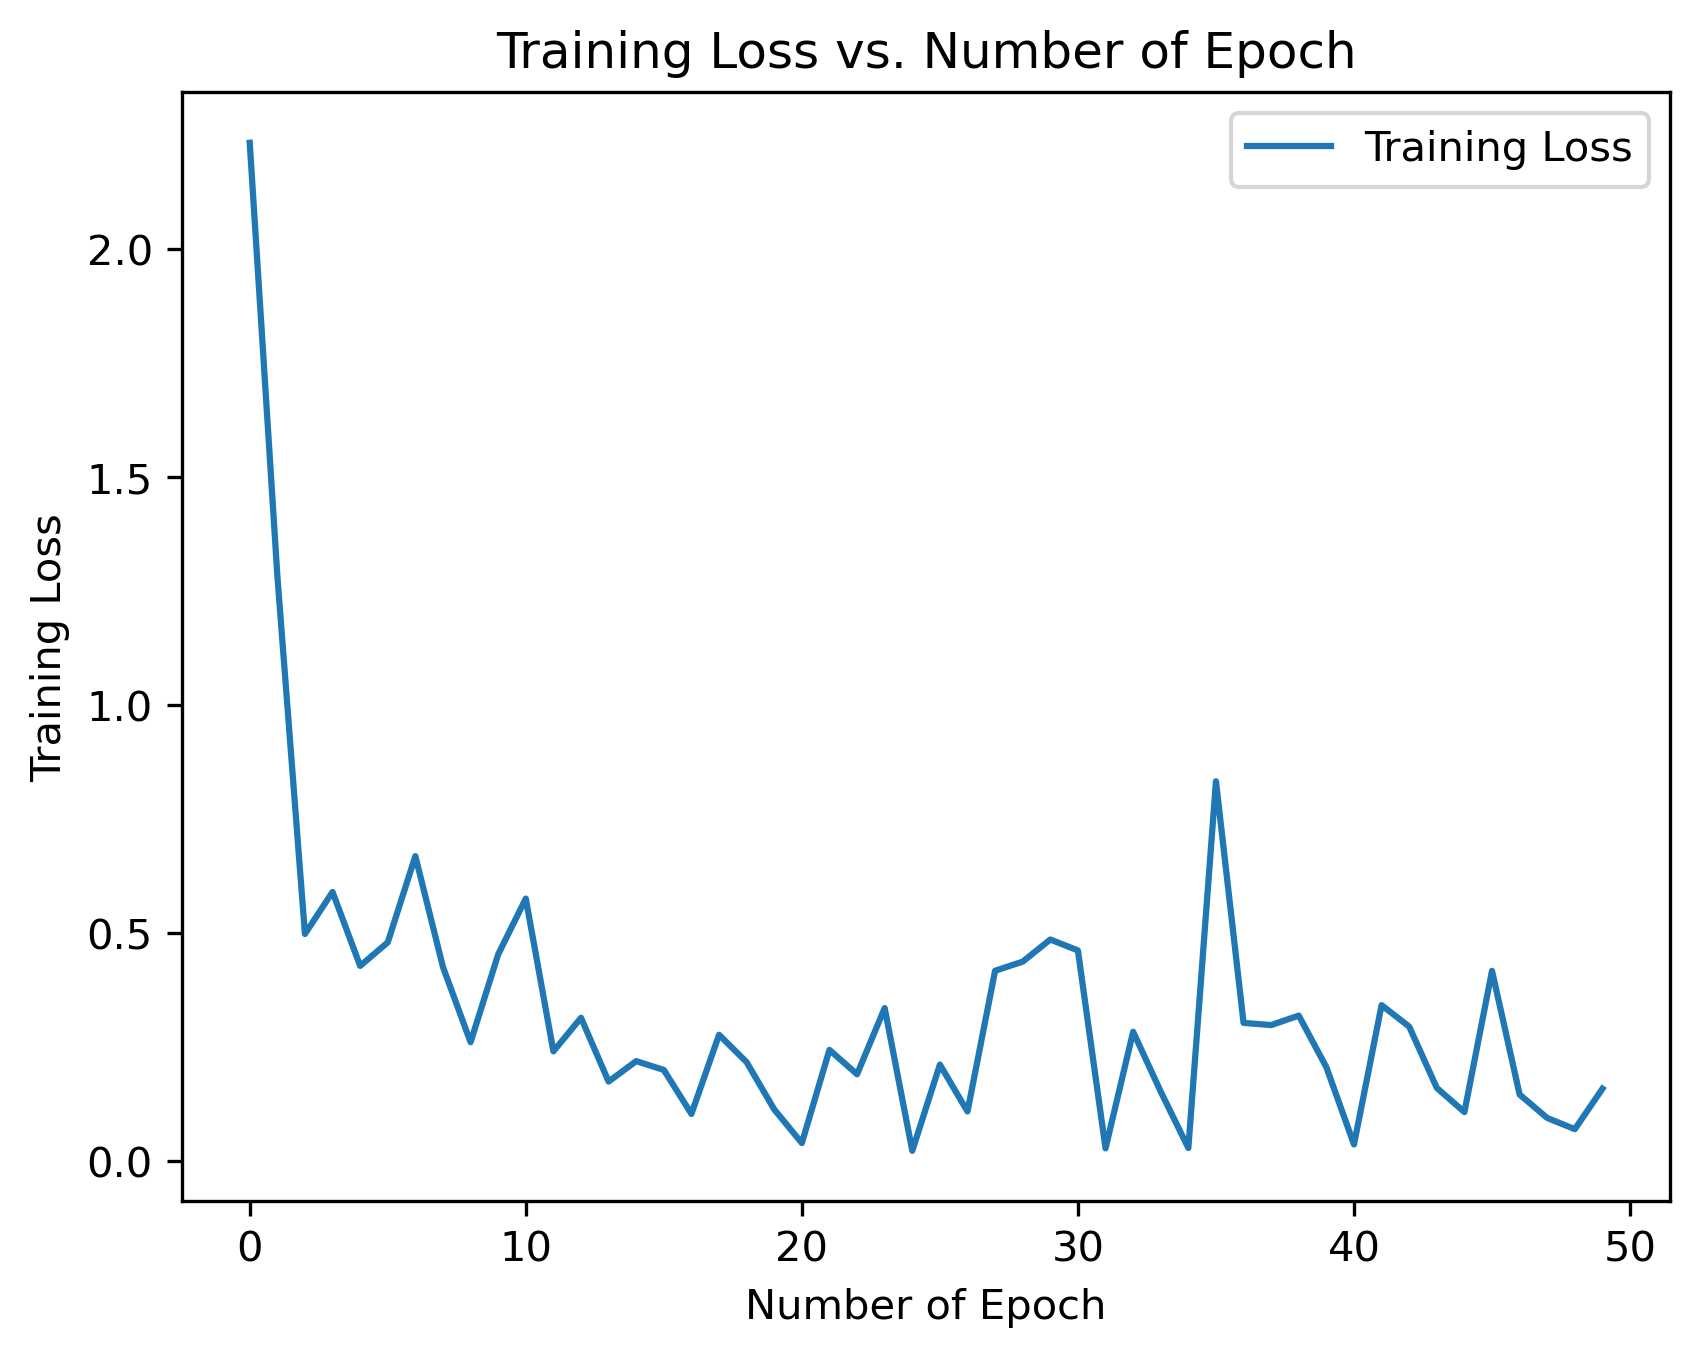

In [104]:
#print(epoch_losses.detach())
#print(len(epoch_losses))
# training loss plot
plt.figure(dpi=300) 
plt.plot([loss.detach().numpy() for loss in epoch_losses])
plt.legend(["Training Loss"])
plt.title("Training Loss vs. Number of Epoch")
plt.xlabel("Number of Epoch")
plt.ylabel("Training Loss")
#choose the right model when running
plt.savefig('loss_plot_model3.png', dpi=300) 
#plt.savefig('loss_plot_model2.png', dpi=300) 
#plt.savefig('loss_plot_model3.png', dpi=300) 

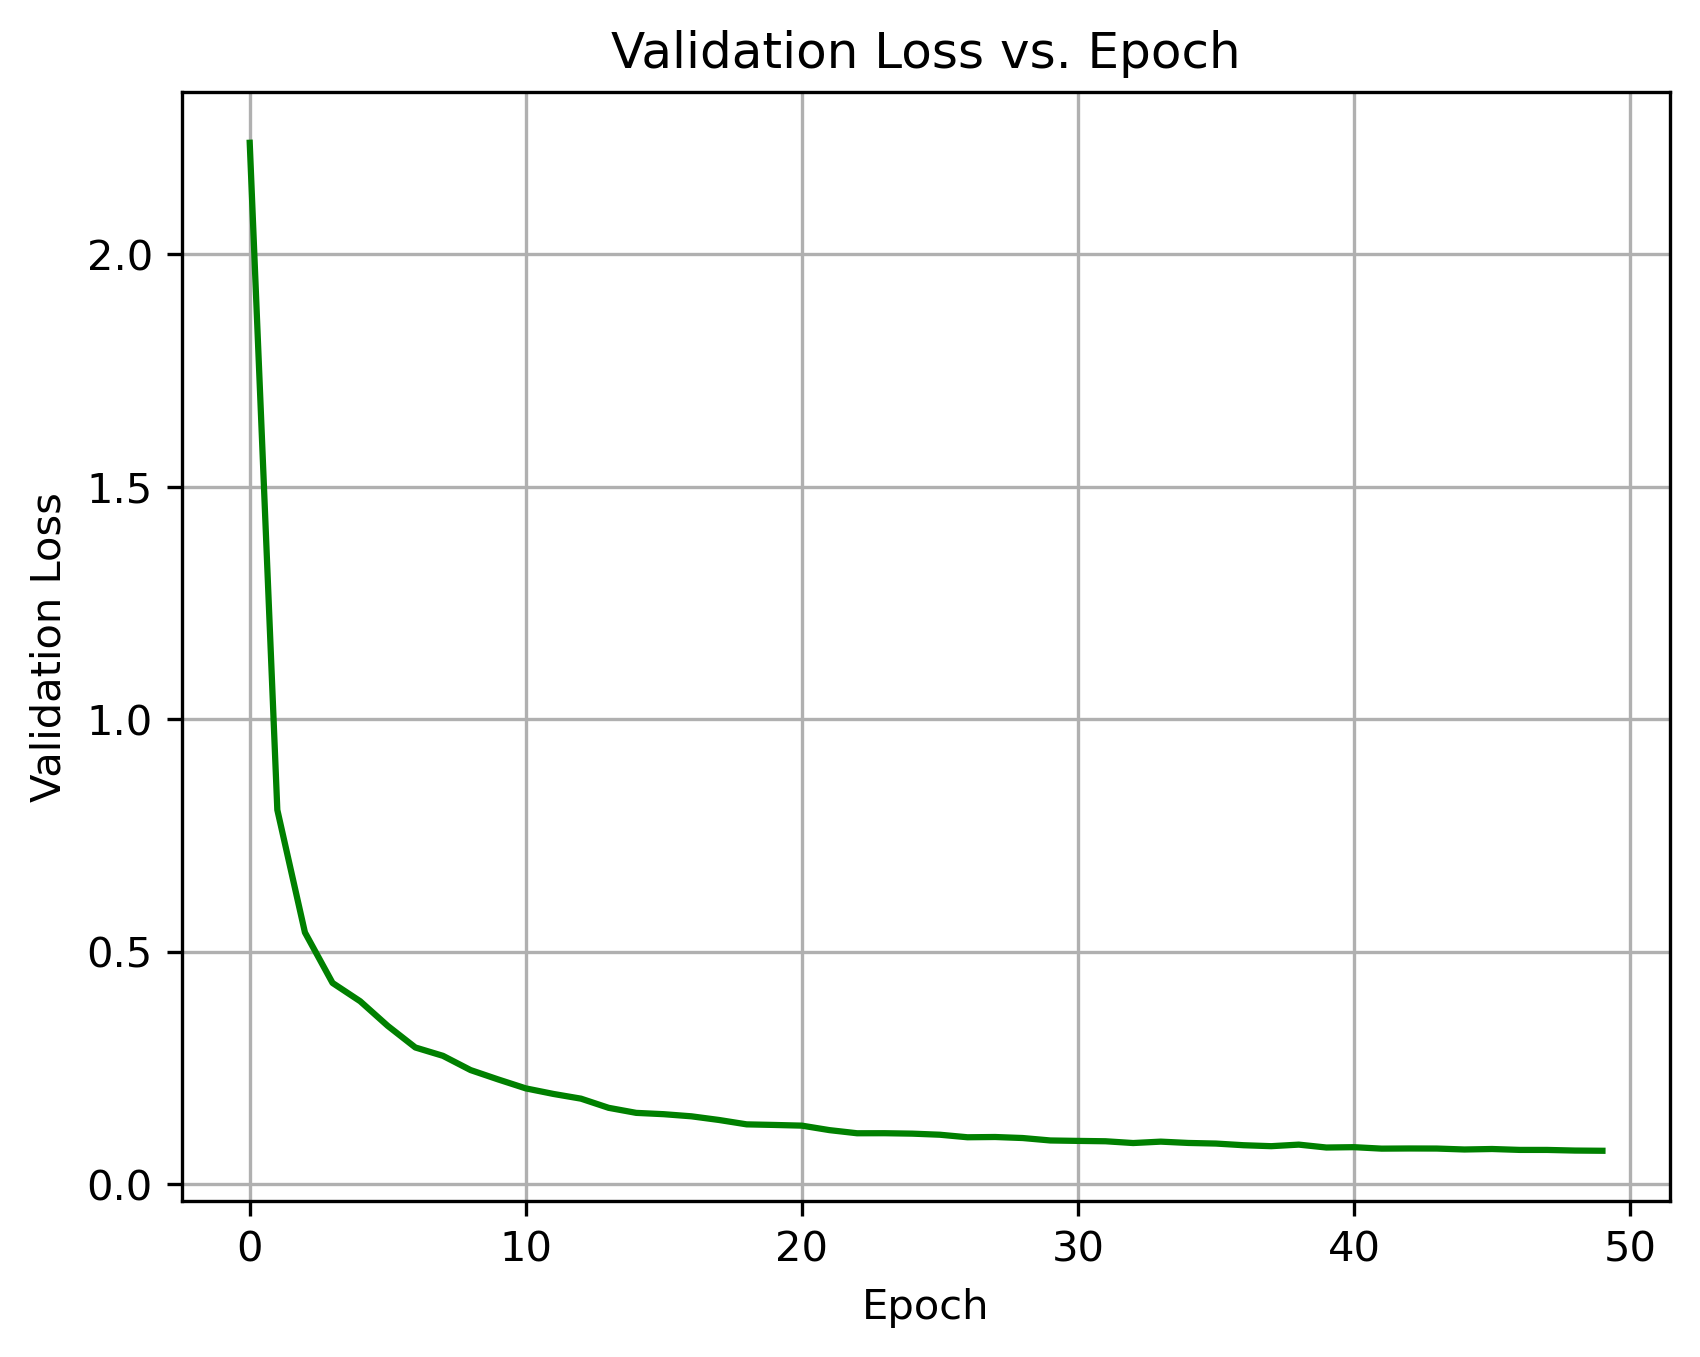

<Figure size 640x480 with 0 Axes>

In [105]:
#print(val_loss)
#print(len(val_loss))
plt.figure(dpi=300)
plt.plot(val_loss, color ='green')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch')
#plt.legend()
plt.grid(True)
plt.show()
#choose the rigth model when saving:
plt.savefig('val_loss_plot_model1.png', dpi=300)
#plt.savefig('val_loss_plot_model2.png', dpi=300) 
#plt.savefig('val_loss_plot_model3.png', dpi=300) 

Precision: 0.976
Recall: 0.976
F1-score: 0.976


<Figure size 1920x1440 with 0 Axes>

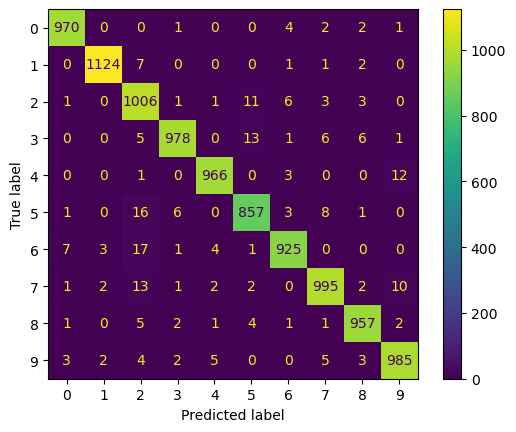

In [106]:
#print confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
model.eval()  
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        out = model(images)
        _, predicted = torch.max(out, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(dpi=300) 
ConfusionMatrixDisplay(conf_matrix).plot()
plt.savefig('confusion_matrix.png', dpi=300)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")